In [ ]:
%pip install scikit-learn matplotlib pandas torch

In [16]:
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, classification_report
import evaluate_binary_models
import importlib

%matplotlib inline

importlib.reload(evaluate_binary_models)

<module 'evaluate_binary_models' from 'c:\\Users\\vico6\\uni\\nitter\\my_nt_instance\\evaluate_binary_models.py'>

Insight into numbers the models will see

In [3]:
# %% 
# 5 first lines of the dataset the models use
# tweet_id, user_id, text (attached with image caption if any), label, deltas and split 
df = pd.read_parquet('data/final.parquet')
print(df.head()) 
print(df.info()) 

              tweet_id              user_id     username             created  \
0  1935331693923275156  1001845274476797954  ACTBrigitte 2025-06-18 13:40:00   
1  1935399911874544084  1001845274476797954  ACTBrigitte 2025-06-18 18:11:00   
2  1935400663770612015  1001845274476797954  ACTBrigitte 2025-06-18 18:14:00   
3  1935401686316564486  1001845274476797954  ACTBrigitte 2025-06-18 18:18:00   
4  1935438003499045172  1001845274476797954  ACTBrigitte 2025-06-18 20:42:00   

                                                text  label_name  label  \
0  The Iran issue is not about regime change, it'...  depression      1   
1  President Trump has the best sense of humor! [...  depression      1   
2  REPORTER: Can you answer questions whether the...  depression      1   
3  Israel is a peace seeking nation. Iran is the ...  depression      1   
4  This is un-American.  Big Pharma and Big Tech ...  depression      1   

   is_english   len_val       neg  ...  emotion_volatility_10tw  \
0

Analyze performance of both models and compare

In [ ]:
# %%
# Load cached predictions and labels for multiclass
d = evaluate_models.load_all()
proba_plain  = d["proba_plain"]
proba_delta  = d["proba_delta"]
pred_plain   = d["pred_plain"]
pred_delta   = d["pred_delta"]
labels       = d["labels"]

In [20]:
# %%
# Load cached predictions and labels for binary
import torch
d = evaluate_binary_models.load_all_binary('depression')
softmax = torch.nn.Softmax(dim=1)
proba_plain = softmax(torch.tensor(d["proba_plain"])).numpy()
proba_delta = softmax(torch.tensor(d["proba_delta"])).numpy()
pred_plain   = d["pred_plain"]
pred_delta   = d["pred_delta"]
labels       = d["labels"]


--- Loading BINARY predictions for 'depression' from cache ---


In [7]:
# %%

# Compute performance summary
def metrics(y_true, y_pred, name):
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    acc = (y_true == y_pred).mean()
    return pd.Series({"model": name, "F1": f, "Precision": p, "Recall": r, "Accuracy": acc})

df_metrics = pd.concat([
    metrics(labels, pred_plain, "Baseline"),
    metrics(labels, pred_delta, "Personalised")
], axis=1).T.set_index("model")

In [8]:
# %%
# Compute metrics for each model
def metrics(y_true, y_pred, name):
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    acc = (y_true == y_pred).mean()
    return pd.Series({"model": name, "F1": f, "Precision": p, "Recall": r, "Accuracy": acc})

df_metrics = pd.concat([
    metrics(labels, pred_plain, "Baseline"),
    metrics(labels, pred_delta, "Personalised")
], axis=1).T.set_index("model")

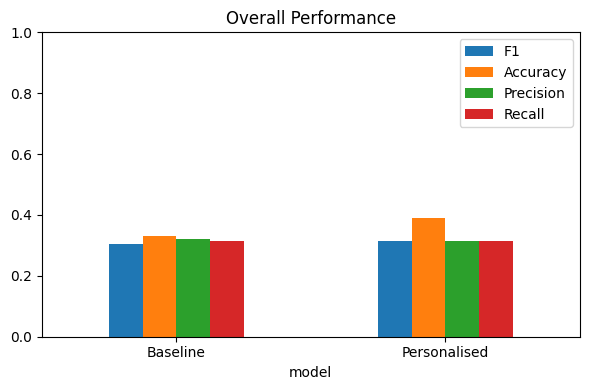

In [19]:
# %%
# Plot overall metrics
df_metrics[["F1", "Accuracy", "Precision", "Recall"]].plot.bar(
    figsize=(6, 4), rot=0)
plt.title("Overall Performance")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

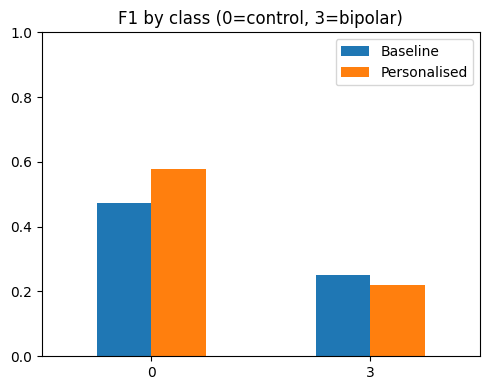

In [37]:
# %%
# Per-class F1 score comparison
rep_plain = classification_report(labels, pred_plain, output_dict=True)
rep_delta = classification_report(labels, pred_delta, output_dict=True)

per_class = pd.DataFrame({
    "Baseline": {k: rep_plain.get(str(k), {}).get("f1-score", 0.0) for k in [0, 3]},
    "Personalised": {k: rep_delta.get(str(k), {}).get("f1-score", 0.0) for k in [0, 3]}
})

per_class.plot(kind="bar", figsize=(5, 4), rot=0)
plt.title("F1 by class (0=control, 3=bipolar)")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

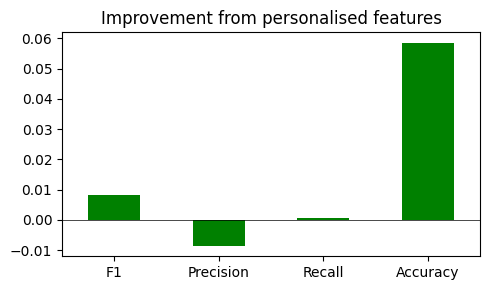

In [11]:
# %%
# How much each metric improved
gain = (df_metrics.loc["Personalised"] - df_metrics.loc["Baseline"]).rename("Δ")
gain.plot(kind="bar", color="green", figsize=(5, 3), rot=0)
plt.title("Improvement from personalised features")
plt.axhline(0, color="k", lw=0.5)
plt.tight_layout()
plt.show()

In [ ]:
#prediction confidence metrics for MULTICLASS 
from collections import Counter
import matplotlib.pyplot as plt

labels = ["control", "anxiety", "depression", "bipolar"]

print(Counter(pred_plain))
print(Counter(pred_delta))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, label in enumerate(labels):
    axes[i].hist(proba_plain[:, i], bins=20, alpha=0.6, label=f"Baseline (p={label})")
    axes[i].hist(proba_delta[:, i], bins=20, alpha=0.6, label=f"Personalised (p={label})")
    axes[i].legend()
    axes[i].set_title(f"Prediction confidence: {label}")
    axes[i].set_xlabel(f"Predicted probability of {label}")
    axes[i].set_ylabel("Tweet count")

plt.tight_layout()
plt.show()


Baseline Prediction Counts:
Counter({np.int64(1): 64832, np.int64(0): 43007})

Delta Prediction Counts:
Counter({np.int64(1): 79807, np.int64(0): 28032})


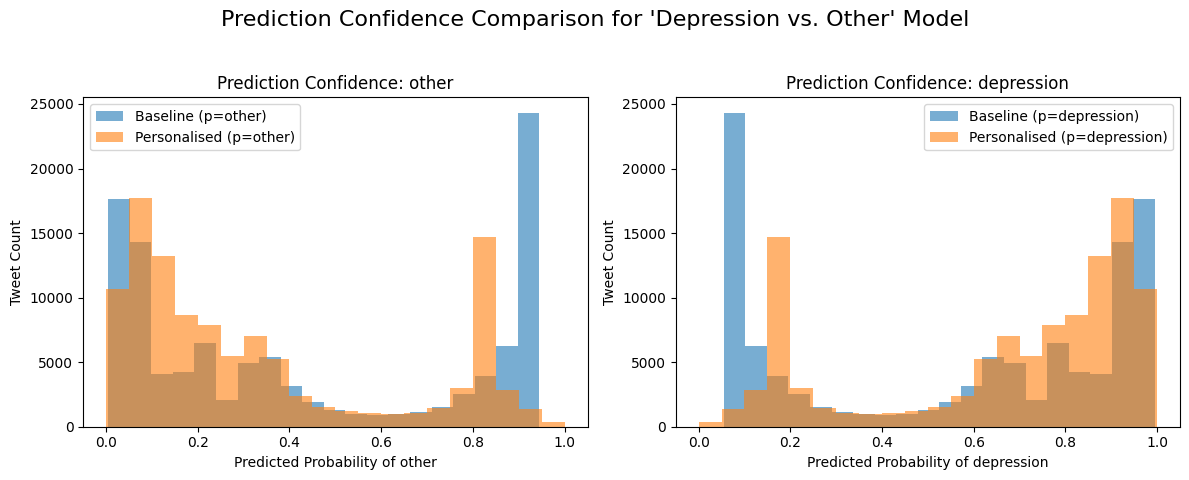

In [21]:

# Prediction confidence metrics for the BINARY model

from collections import Counter
import matplotlib.pyplot as plt

binary_labels = ["other", "depression"] 

print("Baseline Prediction Counts:")
print(Counter(pred_plain)) 
print("\nDelta Prediction Counts:")
print(Counter(pred_delta)) 

fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # Create a plot with 1 row and 2 columns
axes = axes.flatten()

for i, label in enumerate(binary_labels):
    axes[i].hist(proba_plain[:, i], bins=20, alpha=0.6, label=f"Baseline (p={label})")
    axes[i].hist(proba_delta[:, i], bins=20, alpha=0.6, label=f"Personalised (p={label})")
    
    axes[i].legend()
    axes[i].set_title(f"Prediction Confidence: {label}")
    axes[i].set_xlabel(f"Predicted Probability of {label}")
    axes[i].set_ylabel("Tweet Count")

plt.suptitle("Prediction Confidence Comparison for 'Depression vs. Other' Model", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

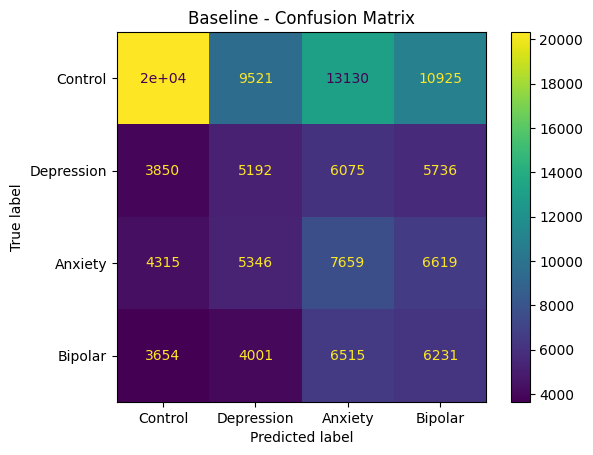

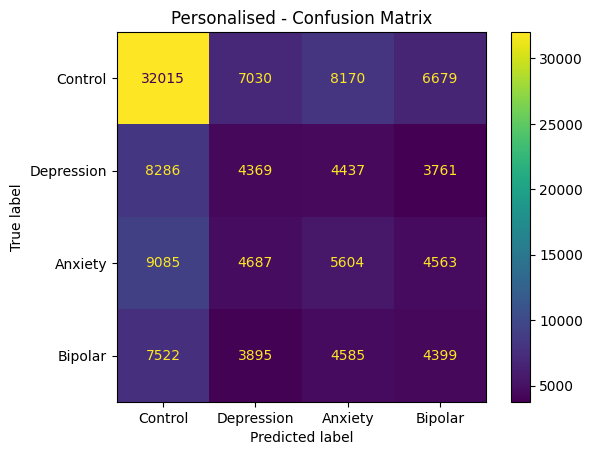

In [31]:
# %%
# Confusion matrices
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(labels, pred_plain, display_labels=["Control", "Depression", "Anxiety", "Bipolar"])
plt.title("Baseline - Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_predictions(labels, pred_delta, display_labels=["Control", "Depression", "Anxiety", "Bipolar"])
plt.title("Personalised - Confusion Matrix")
plt.show()

Counter({np.int64(2): 33379, np.int64(0): 32137, np.int64(3): 29511, np.int64(1): 24060})
Counter({np.int64(0): 56908, np.int64(2): 22796, np.int64(1): 19981, np.int64(3): 19402})


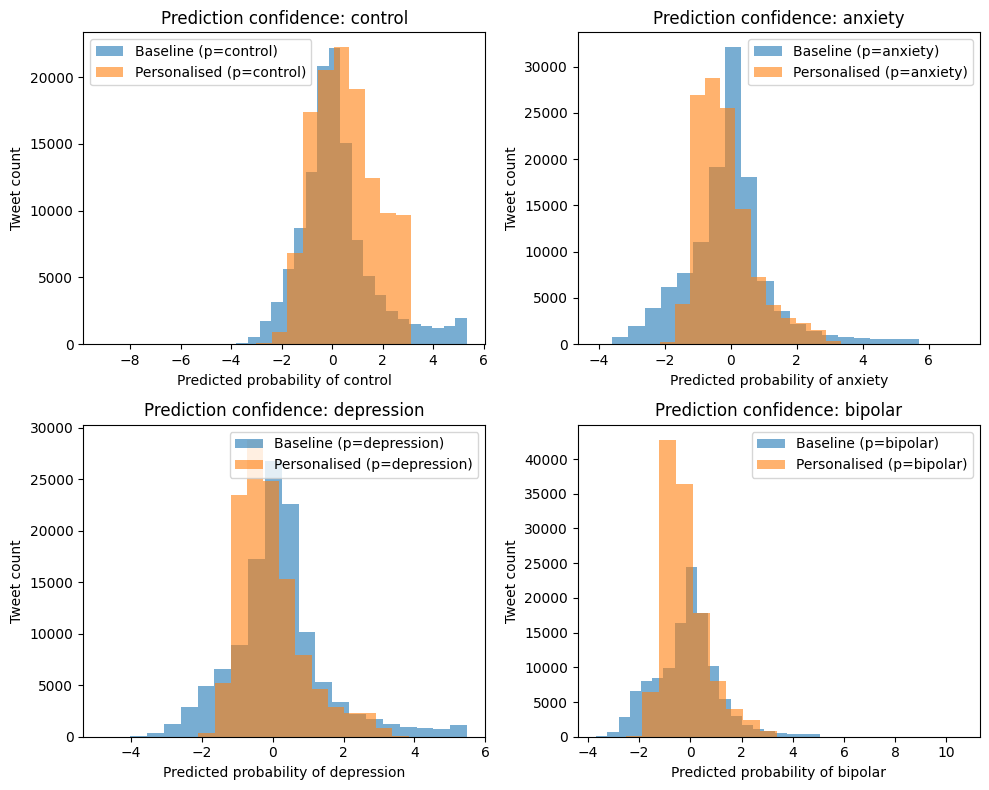

In [27]:
#prediction confidence metrics
from collections import Counter
import matplotlib.pyplot as plt

labels = ["control", "anxiety", "depression", "bipolar"]

print(Counter(pred_plain))
print(Counter(pred_delta))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, label in enumerate(labels):
    axes[i].hist(proba_plain[:, i], bins=20, alpha=0.6, label=f"Baseline (p={label})")
    axes[i].hist(proba_delta[:, i], bins=20, alpha=0.6, label=f"Personalised (p={label})")
    axes[i].legend()
    axes[i].set_title(f"Prediction confidence: {label}")
    axes[i].set_xlabel(f"Predicted probability of {label}")
    axes[i].set_ylabel("Tweet count")

plt.tight_layout()
plt.show()


-----------------------------------------------------------------------

Test the models on new users

--------------------------------------------------

single user with one label

In [6]:
%pip install nltk pandas numpy scipy scikit-learn torch transformers ntscraper requests Pillow tqdm


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# %%
# Import the pipeline
from my_nt_instance.testing_binary_pipeline import TwitterMentalHealthPipeline

# Initialize pipeline
pipeline = TwitterMentalHealthPipeline(
    base_dir="pipeline_data",
    nitter_instance="http://localhost:8080"
)

# Process a single new user
# Label: 0 for control, 1 for condition 
username = "anxietytxtmsgs"  
expected_label = 0  

# Process the user
parquet_path = pipeline.process_user(username, label=expected_label, max_tweets=500)
print(f"Generated parquet at: {parquet_path}")

# Load data
import pandas as pd
df_new = pd.read_parquet(parquet_path)
print(f"Processed {len(df_new)} tweets for @{username}")


Processing user: @anxietytxtmsgs
▸ Scraping timeline for @anxietytxtmsgs
23-Jul-25 19:14:05 - Current stats for anxietytxtmsgs: 20 tweets, 0 threads...
23-Jul-25 19:14:09 - Current stats for anxietytxtmsgs: 40 tweets, 0 threads...
23-Jul-25 19:14:13 - Current stats for anxietytxtmsgs: 60 tweets, 0 threads...
23-Jul-25 19:14:17 - Current stats for anxietytxtmsgs: 80 tweets, 0 threads...
23-Jul-25 19:14:21 - Current stats for anxietytxtmsgs: 100 tweets, 0 threads...
23-Jul-25 19:14:26 - Current stats for anxietytxtmsgs: 120 tweets, 0 threads...
23-Jul-25 19:14:30 - Current stats for anxietytxtmsgs: 140 tweets, 0 threads...
23-Jul-25 19:14:34 - Current stats for anxietytxtmsgs: 160 tweets, 0 threads...
23-Jul-25 19:14:38 - Current stats for anxietytxtmsgs: 180 tweets, 0 threads...
23-Jul-25 19:14:42 - Current stats for anxietytxtmsgs: 200 tweets, 0 threads...
23-Jul-25 19:14:47 - Current stats for anxietytxtmsgs: 220 tweets, 0 threads...
23-Jul-25 19:14:51 - Current stats for anxietytxtm

Captioning: 0it [00:00, ?it/s]


▸ Computing features for @anxietytxtmsgs



✓ Pipeline complete!
  • Processed 400 tweets with deviation features
  • Saved to: pipeline_data\parquets\anxietytxtmsgs_20250723_191545.parquet
Generated parquet at: pipeline_data\parquets\anxietytxtmsgs_20250723_191545.parquet
Processed 400 tweets for @anxietytxtmsgs


In [ ]:
# %%
# Tokenize 
from datasets import Dataset
from evaluate_models import tok_only, tok_plus, load_all

ds_plain = Dataset.from_pandas(df_new).map(tok_only, batched=True, remove_columns=list(df_new.columns))
ds_delta = Dataset.from_pandas(df_new).map(tok_plus, batched=True, remove_columns=list(df_new.columns))

Map: 100%|██████████| 400/400 [00:00<00:00, 13258.43 examples/s]


In [ ]:
# %%
# Load models 
plain_trainer, delta_trainer, *_ = load_all()

Map: 100%|██████████| 4497/4497 [00:00<00:00, 13191.27 examples/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# %%
import numpy as np
# Get predictions on new users
proba_plain  = plain_trainer.predict(ds_plain).predictions
proba_delta  = delta_trainer.predict(ds_delta).predictions
pred_plain   = proba_plain.argmax(1)
pred_delta   = proba_delta.argmax(1)
labels       = np.array(df_new["label"])

c:\Users\vico6\uni\nitter\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Counter({np.int64(1): 376, np.int64(0): 24})
Counter({np.int64(1): 380, np.int64(0): 20})


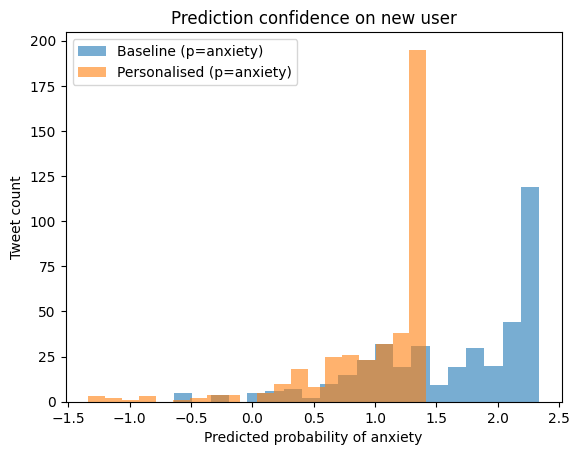

In [ ]:
# %%
#  prediction confidence metrics
from collections import Counter
import matplotlib.pyplot as plt

print(Counter(pred_plain))    
print(Counter(pred_delta))

# add condition name in label
plt.hist(proba_plain[:,1], bins=20, alpha=0.6, label="Baseline (p=anxiety)")
plt.hist(proba_delta[:,1], bins=20, alpha=0.6, label="Personalised (p=anxiety)")
plt.legend()
plt.title("Prediction confidence on new user")
plt.xlabel("Predicted probability of anxiety")
plt.ylabel("Tweet count")
plt.show()


-----------------------------------------------------------

multiple users with different labels

In [ ]:
# %%
# Import the pipeline
from testing_pipeline import TwitterMentalHealthPipeline

# Initialize pipeline
pipeline = TwitterMentalHealthPipeline(
    base_dir="pipeline_data",
    nitter_instance="http://localhost:8080"
)

# Process a single new user
# Label: 0 for control, 1 for condition 
username = "anxietytxtmsgs"  
expected_label = 0  

# Process the user
parquet_path = pipeline.process_user(username, label=expected_label, max_tweets=500)
print(f"Generated parquet at: {parquet_path}")

# Load data
import pandas as pd
df_new = pd.read_parquet(parquet_path)
print(f"Processed {len(df_new)} tweets for @{username}")

In [26]:
# %%
#  Metrics for multiple users with different labels
from sklearn.metrics import classification_report

print("Baseline model:\n", classification_report(labels, pred_plain, digits=3))
print("Personalised model:\n", classification_report(labels, pred_delta, digits=3))

Baseline model:
               precision    recall  f1-score   support

           0      0.632     0.377     0.472     53894
           1      0.216     0.249     0.231     20853
           2      0.229     0.320     0.267     23939
           3      0.211     0.305     0.250     20401

    accuracy                          0.331    119087
   macro avg      0.322     0.313     0.305    119087
weighted avg      0.406     0.331     0.351    119087

Personalised model:
               precision    recall  f1-score   support

           0      0.563     0.594     0.578     53894
           1      0.219     0.210     0.214     20853
           2      0.246     0.234     0.240     23939
           3      0.227     0.216     0.221     20401

    accuracy                          0.390    119087
   macro avg      0.313     0.313     0.313    119087
weighted avg      0.381     0.390     0.385    119087



In [ ]:
# %%
# ROC Curves
from sklearn.metrics import roc_curve, auc

fpr_b, tpr_b, _ = roc_curve(labels, proba_plain[:, 1])
fpr_d, tpr_d, _ = roc_curve(labels, proba_delta[:, 1])

plt.plot(fpr_b, tpr_b, label=f"Baseline (AUC={auc(fpr_b, tpr_b):.3f})")
plt.plot(fpr_d, tpr_d, label=f"Personalised (AUC={auc(fpr_d, tpr_d):.3f})")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Unseen Users")
plt.legend()
plt.tight_layout()
plt.show()

-------------------------------------------------

User-level example of baseline deviation and personalization 

-------------------------------------------------

In [ ]:

df = pd.read_parquet(DATA_FILE)

# Filter to only include users from the test set
test_users_df = df[df['split'] == 'test']
test_user_ids = test_users_df['user_id'].unique().tolist()
if not test_user_ids:
    raise ValueError("No users found in the 'test' split of the dataset.")

# Select a user ID at random from the test set
TARGET_USER_ID = random.choice(test_user_ids)
print(f"--- RANDOMLY SELECTED USER: {TARGET_USER_ID} ---")

# Isolate all processed tweets for this user from the main dataframe
user_df = df[df['user_id'] == TARGET_USER_ID].sort_values('created').reset_index(drop=True)

print(f"Found {len(user_df)} processed tweets for this user.")
true_label_name = user_df['label_name'].iloc[0]
print(f"This user's ground truth label is: {true_label_name.upper()}")

In [ ]:
#Find and Display the "Shift Week

# Create a 'week' column to group tweets by
user_df['week'] = pd.to_datetime(user_df['created']).dt.to_period('W')

# Find the single tweet with the highest (most abnormal) anomaly score
peak_anomaly_tweet = user_df.loc[user_df['anomaly_score'].idxmax()]
shift_week = peak_anomaly_tweet['week']

# Select all other tweets from that same week
shift_df = user_df[user_df['week'] == shift_week].copy()

print(f"Found a period of significant behavioral shift during the week of: {shift_week.start_time.date()}")
print(f"This week contains the user's peak anomaly tweet with a score of: {peak_anomaly_tweet['anomaly_score']:.3f}")

print("\n--- Tweets from the Shift Week (note the changing feature values) ---")
display_df = pd.concat([
    peak_anomaly_tweet.to_frame().T,
    shift_df.drop(peak_anomaly_tweet.name, errors='ignore')
])
display(display_df[['created', 'text', 'anomaly_score', 'circadian_deviation', 'sent_compound_z']].head())


Found a period of significant behavioral shift during the week of: 2023-12-25
This week contains the user's peak anomaly tweet with a score of: 15.307

--- Tweets from the Shift Week (note the changing feature values) ---


,created,text,anomaly_score,circadian_deviation,sent_compound_z
150,2023-12-31 18:19:00,"Before AJ's fight with Wallin, a lot of people thought he'd lose... since the fight a lot are saying Wallin is washe...",15.307125,0.198302,-2.290985
149,2023-12-27 20:48:00,Harrison's mum is getting fucking slotted by a blue tonight 😆😆🥰💙 #EVEMCI #SpiritOfTheBlues [IMG_CAP],2.236313,0.594907,-0.495057


In [9]:
# %% [code]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# --- Load Baseline Model ---
baseline_model = AutoModelForSequenceClassification.from_pretrained(BASELINE_DIR).to(device).eval()

# --- Load Delta Model ---
delta_config = AutoConfig.from_pretrained(DELTA_DIR)
num_features_trained = delta_config.custom_num_features
delta_model = AdvancedDeltaModel(config=delta_config).to(device)
weights_path = os.path.join(DELTA_DIR, "model.safetensors")
if not os.path.exists(weights_path): weights_path = os.path.join(DELTA_DIR, "pytorch_model.bin")
from safetensors.torch import load_file
state_dict = load_file(weights_path, device=str(device)) if weights_path.endswith(".safetensors") else torch.load(weights_path, map_location=device)
delta_model.load_state_dict(state_dict)
delta_model.eval()

# --- Prepare Datasets for the Shift Week ---
shift_df = shift_df.drop(columns=['week'])
shift_ds = Dataset.from_pandas(shift_df)
def tok_only(batch): return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)
plain_ds_shift = shift_ds.map(tok_only, batched=True, remove_columns=shift_ds.column_names)
plain_ds_shift.set_format(type='torch', columns=['input_ids', 'attention_mask'])

selected_features = get_feature_list(df, n_features=num_features_trained)
def tok_plus(batch):
    encoding = tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)
    encoding["delta"] = [[float(batch[c][i]) if c in batch and pd.notna(batch[c][i]) else 0.0 for c in selected_features] for i in range(len(batch["text"]))]
    return encoding
delta_ds_shift = shift_ds.map(tok_plus, batched=True, remove_columns=shift_ds.column_names)
delta_ds_shift.set_format(type='torch', columns=['input_ids', 'attention_mask', 'delta'])

# --- Run Inference ---
with torch.no_grad():
    plain_loader = DataLoader(plain_ds_shift, batch_size=32)
    delta_loader = DataLoader(delta_ds_shift, batch_size=32)
    
    baseline_logits = []
    for batch in plain_loader:
        batch = {k: v.to(device) for k,v in batch.items()}
        baseline_logits.append(baseline_model(**batch).logits.cpu().numpy())
    
    delta_logits = []
    for batch in delta_loader:
        batch = {k: v.to(device) for k,v in batch.items()}
        delta_logits.append(delta_model(**batch)['logits'].cpu().numpy())

shift_df['baseline_pred'] = np.concatenate(baseline_logits).argmax(axis=1)
shift_df['delta_pred'] = np.concatenate(delta_logits).argmax(axis=1)

id2label = delta_config.id2label
shift_df['baseline_label'] = shift_df['baseline_pred'].map(id2label)
shift_df['delta_label'] = shift_df['delta_pred'].map(id2label)
print("\nInference complete.")


# display
print(f"--- Prediction Comparison for User {TARGET_USER_ID} during Shift Week ---")
print(f"Ground Truth Label for this user is: {true_label_name.upper()}\n")

baseline_counts = shift_df['baseline_label'].value_counts()
delta_counts = shift_df['delta_label'].value_counts()

comparison_df = pd.DataFrame({
    'Baseline Predictions': baseline_counts,
    'Delta Predictions': delta_counts
}).fillna(0).astype(int)

print("Prediction counts for the week:")
display(comparison_df)

print("\nExample Tweets and Predictions:")
display(shift_df[['text', 'baseline_label', 'delta_label']].head(15))

Some weights of RobertaModel were not initialized from the model checkpoint at out/delta_final2 and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer


Inference complete.
--- Prediction Comparison for User 1792623176779739136 during Shift Week ---
Ground Truth Label for this user is: ANXIETY

Prediction counts for the week:


,Baseline Predictions,Delta Predictions
anxiety,0,1
bipolar,2,1



Example Tweets and Predictions:


,text,baseline_label,delta_label
149,Harrison's mum is getting fucking slotted by a blue tonight 😆😆🥰💙 #EVEMCI #SpiritOfTheBlues [IMG_CAP],bipolar,anxiety
150,"Before AJ's fight with Wallin, a lot of people thought he'd lose... since the fight a lot are saying Wallin is washe...",bipolar,bipolar
